#Loading and Understanding the data

In this colab we will get the data we just collected through CoolTerm, load it, and understad it.



In [1]:
#Get the necessary packages (importing libraries and dependecies)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from scipy import stats

#set the threshhold of prinitng data to console to maximum value
#so avoid the loss of data on console while displaying
np.set_printoptions(threshold=sys.maxsize)
# setting up a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

##Get the data

You will have to manually upload the .txt files in colab (for now) in order to get access to the raw data.

We will define a function **readData()** to get access in the .txt files and also give names to the columns.

🔑**Note:** We start with a smaller datset so we can experiment quickly and experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [2]:
#--------------To read the data from a file
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [3]:
# Read The Data
capture = "1"
hertz = "60"
volume = "30"
filename = "capture" + capture + "_" + hertz + "hz_" + volume + "vol.txt"
dataset = readData(filename)

# Add a new column for sequential timestamps
dataset['timestamp'] = np.arange(1, len(dataset) + 1)

dataset

,x-axis,y-axis,z-axis,timestamp
0,0.03,-0.07,0.70,1
1,-0.10,0.04,1.20,2
2,0.03,-0.07,0.71,3
3,-0.10,0.04,1.20,4
4,0.03,-0.07,0.71,5
...,...,...,...,...
36309,-0.01,-0.01,0.96,36310
36310,-0.00,0.01,1.14,36311
36311,-0.01,-0.01,0.97,36312
36312,-0.00,0.01,1.14,36313


## Inspect the data (become one with it)

A very crucial step at the beginning of any ML project is becoming one with the data. So we saw that the data was properly place in the *dataset* variable. Now, in order to have a better visualization of the data we will plot it.

In [4]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

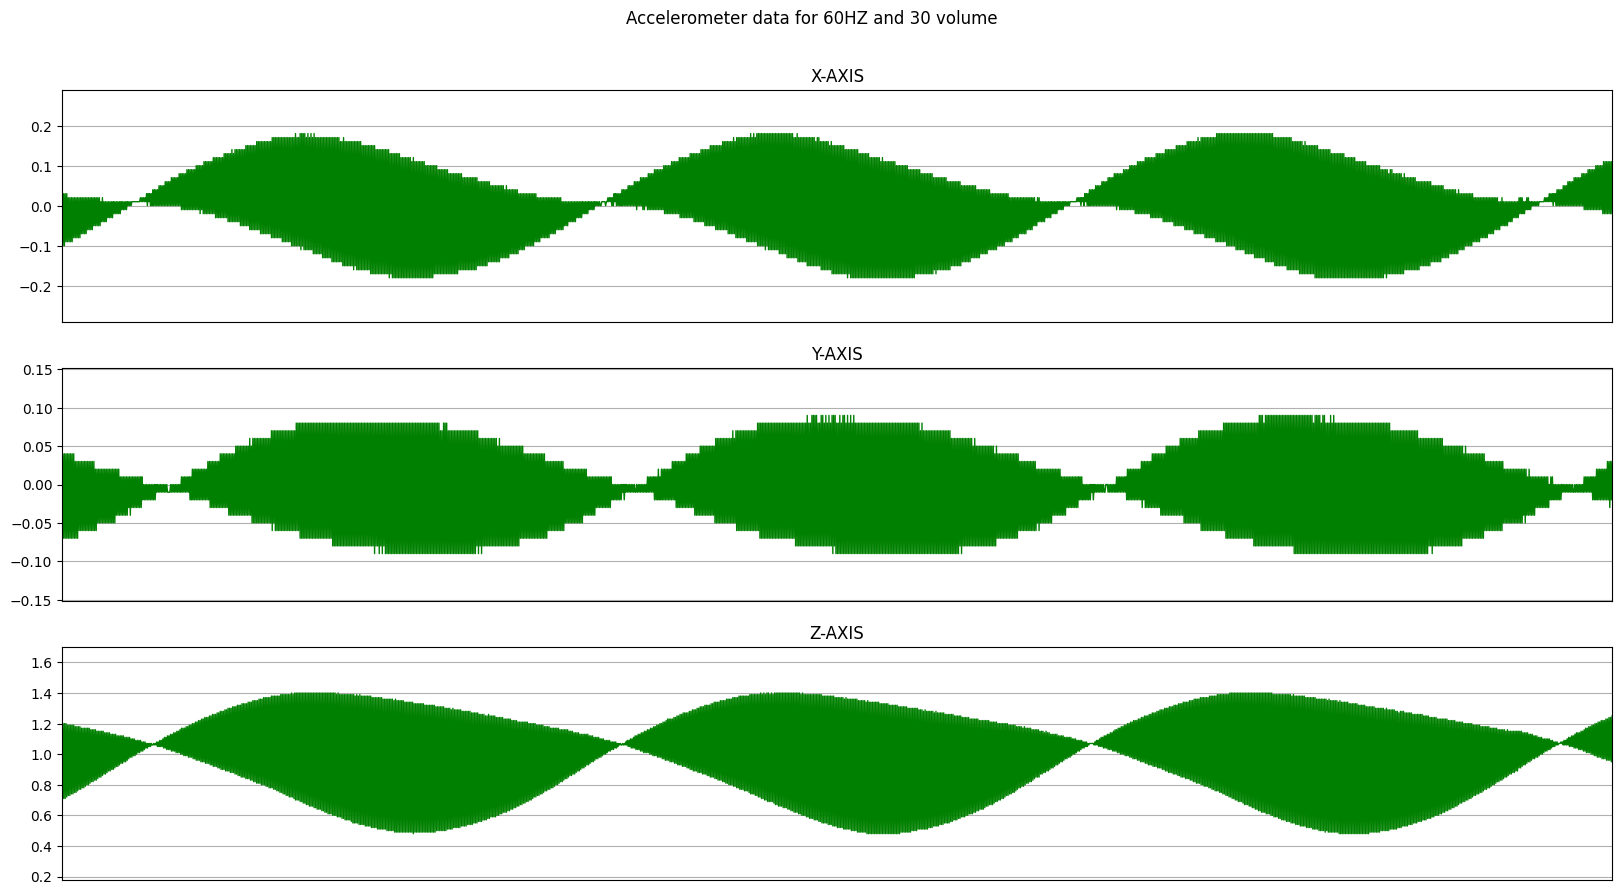

In [5]:
#select a subset of 2000 samples
subset = dataset[:2000]
plotVibPattern(subset, hertz, volume)


OK! we can definitely see a pattern in all 3 datasets we gathered.

I will now continue testing and also preprocessing the data from the 60hz and 30 volume dataset.

In [6]:
# Pick a random row from the dataset
random_reading = dataset.sample(n=1)

# our data is actually giant arrays/tensors
#ternsors are inputs to our neural networks
tf.constant(random_reading)

#you can also see the entire dataset as tensors (it'll take a bit longer to compute)
#using this command: tf.constant(dataset)
tf.constant(dataset)

<tf.Tensor: shape=(36314, 4), dtype=float64, numpy=
array([[ 3.0000e-02, -7.0000e-02,  7.0000e-01,  1.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  2.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  3.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  4.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  5.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.2000e+00,  6.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.2000e-01,  7.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  8.0000e+00],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  9.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.0000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  1.1000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.2000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.3000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.4000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.5000e+01],
       [-8.0000e-02,  4.0000e-02,

In [7]:
#view the image shape
random_reading.shape #returns one row, 4 columns

(1, 4)

##Splitting the data
Now that we have a reasonable dataset we can work with it is time to start thinking about our neural network. Hence, the first step is to split the data.

I will use the cross-validation method so that we can also test the generazibility of the model.

Partition the data into training and validation, and testing partitions. Train the network using the 70% of the data and 20% for validaiton. Then, set aside 10% for testing.

In this code, train_test_split is used twice to first split the data into training (70%) and a combination of validation and testing (30%). Then, the validation and testing sets are split from the combined set, resulting in a 20% validation set and a 10% testing set.

In [8]:
from sklearn.model_selection import train_test_split

# Splitting the data into 70% training, 20% validation, and 10% testing without shuffling
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42, shuffle=False)

# Print the shapes of the resulting sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (25419, 4)
Validation data shape: (7299, 4)
Testing data shape: (3596, 4)


In [9]:
dataset.shape

(36314, 4)

##Preprocessing the data

🔑**Note**: As we've discussed before, many ML models, including NNs prefer the values they work with the be between 0 and 1. Knowing this, one of the most common preprocessing steps  is to **normalize** the data. In our case, having just values which are in a certain range we can apply the Min-Max scaling formula.

In [10]:
# defining a function to normalize data
def normalize(dataset):
  # Define the min and max values for x-axis, y-axis, and z-axis
  min_values_xyz = np.min(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)
  max_values_xyz = np.max(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)

  # Apply Min-Max scaling to x-axis, y-axis, and z-axis
  normalized_xyz = (dataset[['x-axis', 'y-axis', 'z-axis']] - min_values_xyz) / (max_values_xyz - min_values_xyz)

  # Combine the normalized values with the 'timestamp' column
  normalized_data = pd.concat([normalized_xyz, dataset['timestamp']], axis=1)

  return normalized_data

In [11]:
norm_train_data = normalize(train_data)
norm_val_data = normalize(val_data)
norm_test_data = normalize(test_data)

In [12]:
norm_train_data

,x-axis,y-axis,z-axis,timestamp
0,0.565217,0.208333,0.275510,1
1,0.282609,0.666667,0.785714,2
2,0.565217,0.208333,0.285714,3
3,0.282609,0.666667,0.785714,4
4,0.565217,0.208333,0.285714,5
...,...,...,...,...
25414,0.521739,0.291667,0.418367,25415
25415,0.391304,0.583333,0.755102,25416
25416,0.500000,0.291667,0.428571,25417
25417,0.413043,0.583333,0.755102,25418


To verify that the behaviour did not change after the normalization we can plot again on the newly updated data.

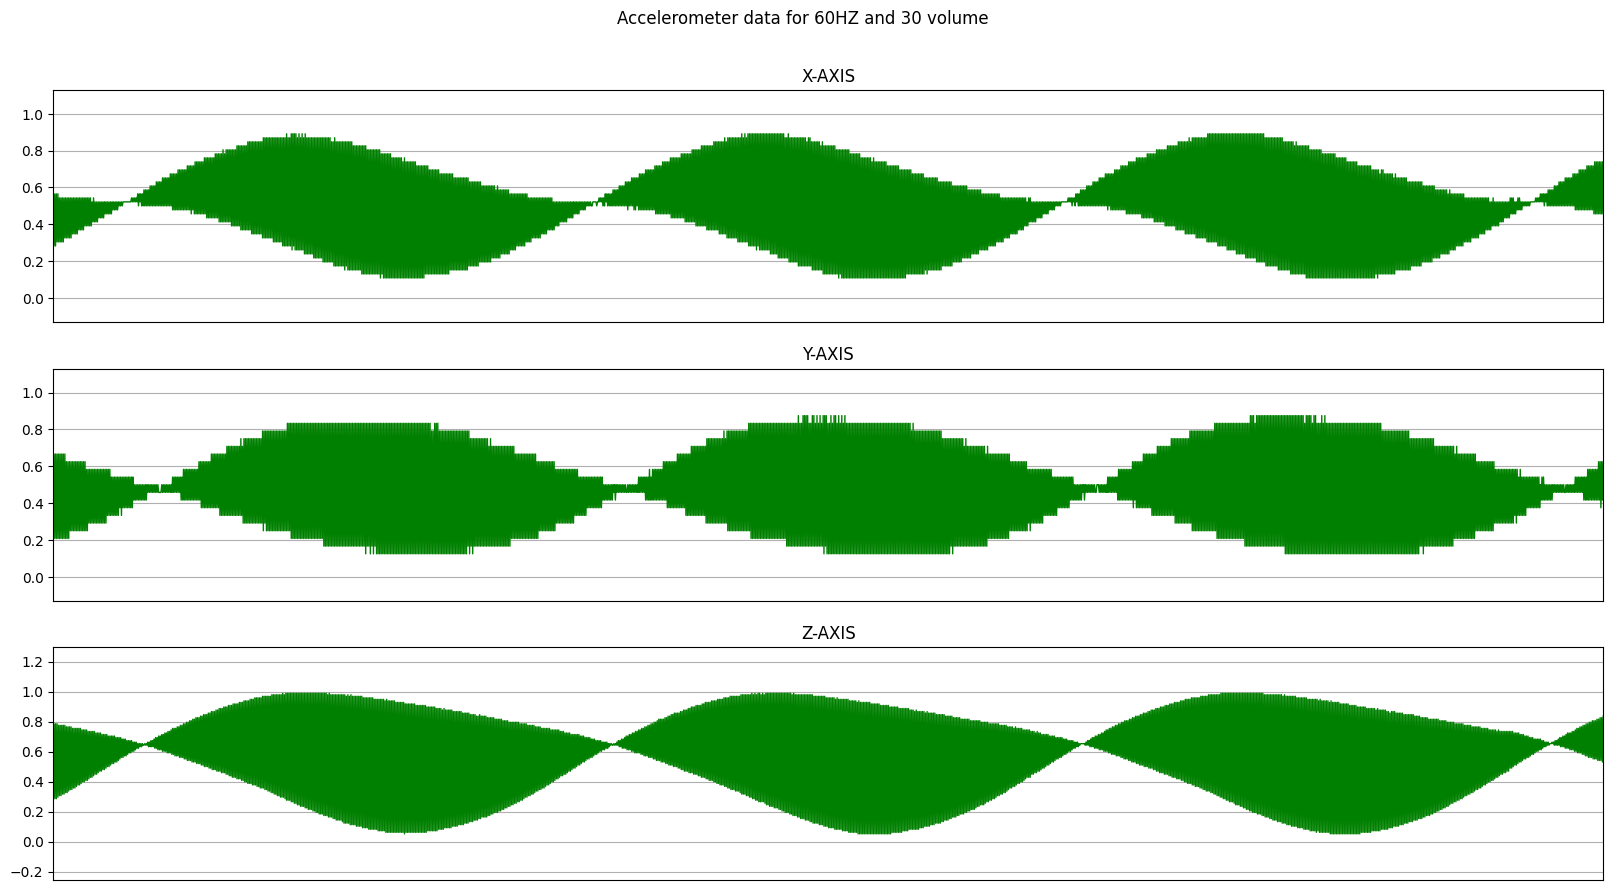

In [13]:
#select a subset of 2000 samples
subset = norm_train_data[:2000]
plotVibPattern(subset, hertz, volume)

As seen in the plot, the behaviour is intact which is exactly what we wanted.

In [17]:
# Drop the 'timestamp' column
norm_train_data = norm_train_data.drop(columns=['timestamp'])
norm_val_data = norm_val_data.drop(columns=['timestamp'])
norm_test_data = norm_test_data.drop(columns=['timestamp'])

## Picking an Embedding to Build the Model

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. We can also go for layer sizes (we need to experiment).

In [18]:


from keras.models import Model
from keras import layers, losses

class AnomalyDetector(Model):
  # This is the constructor method for the AnomalyDetector class, where the architecture of the autoencoder is defined.
  def __init__(self):
    #calls the constructor of the parent class (tf.keras.Model) to properly initialize the model.
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", input_shape = (3, )),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")]) # Smallest Layer Defined Here

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(3, activation="sigmoid")])

  #This method defines the forward pass of the autoencoder model. It takes the input x, which represents the ECG signals.
  #The x is first passed through the encoder, and the resulting compressed representation is obtained.
  #The compressed representation is then passed through the decoder to reconstruct the original ECG signals.
  #The reconstructed signals are returned as the output of the autoencoder.
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

#This line creates an instance of the AnomalyDetector class, creating an autoencoder model.
autoencoder = AnomalyDetector()

In [19]:
#MAE measures the absolute difference between the original input and the reconstructed output and is commonly used for autoencoders.
autoencoder.compile(optimizer='adam', loss='mae')

## Train the model

Notice that the autoencoder is trained using only the normal accelerometer data, but is evaluated using the full test set.

- train_data: The input data used for training the autoencoder. This consists of normal (non-anomalous) accelerometer data.
- train_data: The target data used for training. In this case, the target data is the same as the input data because the autoencoder aims to reconstruct the input data.
- epochs=50: The number of epochs represents how many times the entire training dataset will be used to train the model. One epoch means the model has seen each data point in the training set once.
- batch_size=512: The batch size specifies the number of data points that will be fed to the model in each iteration during training. A larger batch size might lead to faster training, but it requires more memory.
- validation_data=(test_data, test_data): During training, this data is used to evaluate the model's performance after each epoch. The test_data can contains normal accelerometer data for validation.
- shuffle=True: If True, the training data will be shuffled at the beginning of each epoch. Shuffling the data helps in reducing the bias introduced by the order of the data points during training.

After training, the autoencoder model will be capable of compressing and reconstructing ECG signals. In an anomaly detection setting, the model can be used to detect anomalies by comparing the reconstruction error of test (normal and anomalous) ECG signals with the reconstruction error of normal training data. Anomalies are expected to have higher reconstruction errors compared to normal data.

In [20]:
history = autoencoder.fit(norm_train_data, norm_train_data,
          epochs=50,
          batch_size=512,
          validation_data=(norm_val_data, norm_val_data),
          shuffle=True)

Epoch 1/50
50/50 [==============================] - 3s 13ms/step - loss: 0.2446 - val_loss: 0.1920
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1169 - val_loss: 0.0813
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0606 - val_loss: 0.0627
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0547 - val_loss: 0.0582
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0539
Epoch 6/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0473 - val_loss: 0.0506
Epoch 7/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.0489
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0432 - val_loss: 0.0478
Epoch 9/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0461
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0396 - val_loss: 0.0443
Epoch 11/50
50/50 

Checking for overfitting

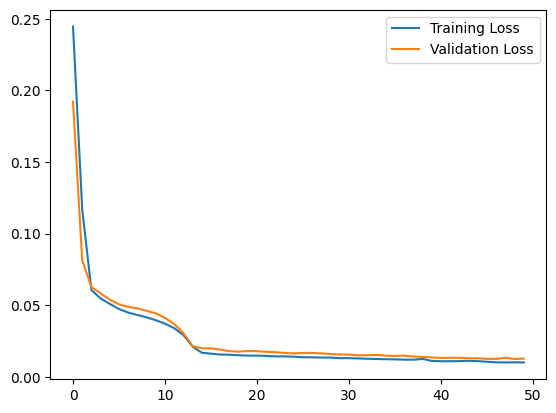

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Evaluate Training

We will now test if the model has indeed learn the patterns correcly by using our test_data which was not used in the training process. We will encode it and decode it (basically mimic the same process as in training) and see if the pattern stays the same or changes drammatically. If the pattern is similar it means our model has indeed learnt the features successfully.

In [22]:
print(type(norm_test_data))

<class 'pandas.core.frame.DataFrame'>


In [25]:
norm_test_data

,x-axis,y-axis,z-axis
32718,0.577778,0.500000,0.683673
32719,0.444444,0.538462,0.642857
32720,0.600000,0.500000,0.683673
32721,0.444444,0.538462,0.642857
32722,0.600000,0.500000,0.673469
...,...,...,...
36309,0.466667,0.500000,0.540816
36310,0.488889,0.576923,0.724490
36311,0.466667,0.500000,0.551020
36312,0.488889,0.576923,0.724490


In [26]:
sample = norm_test_data.iloc[:, :].to_numpy()

In [27]:
sample.shape

(3596, 3)

In [28]:
encoded_imgs = autoencoder.encoder(sample).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Create an array representing the timestamp
timestamp = np.arange(3596)

In [29]:
def plotAxis(axis, x, y, colour):
    axis.plot(x, y, color=colour, linewidth=1)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

def plotVibPattern(original, decoded, timestamp):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, timestamp, original[:, 0], 'green')  # Accessing the first column
    plotAxis(ax0, timestamp, decoded[:, 0], 'red')  # Accessing the first column
    plotAxis(ax1, timestamp, original[:, 1], 'green')  # Accessing the second column
    plotAxis(ax1, timestamp, decoded[:, 1], 'red')  # Accessing the first column
    plotAxis(ax2, timestamp, original[:, 2], 'green')  # Accessing the third column
    plotAxis(ax2, timestamp, decoded[:, 2], 'red')  # Accessing the first column
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.9)
    plt.show()

if you want to see more samples or to see another part of the decoding you can play around with the timestamp value and also from where in the original and decoded subset should the plotting start

In [30]:
# Assuming subset is a NumPy array, not a DataFrame
timestamp = 2000
subset_original = sample[1000:3000]
subset_decoded = decoded_imgs[1000:3000]
timestamp = np.array([i for i in range(timestamp)])  # Convert to a NumPy array

In [31]:
timestamp.shape

(2000,)

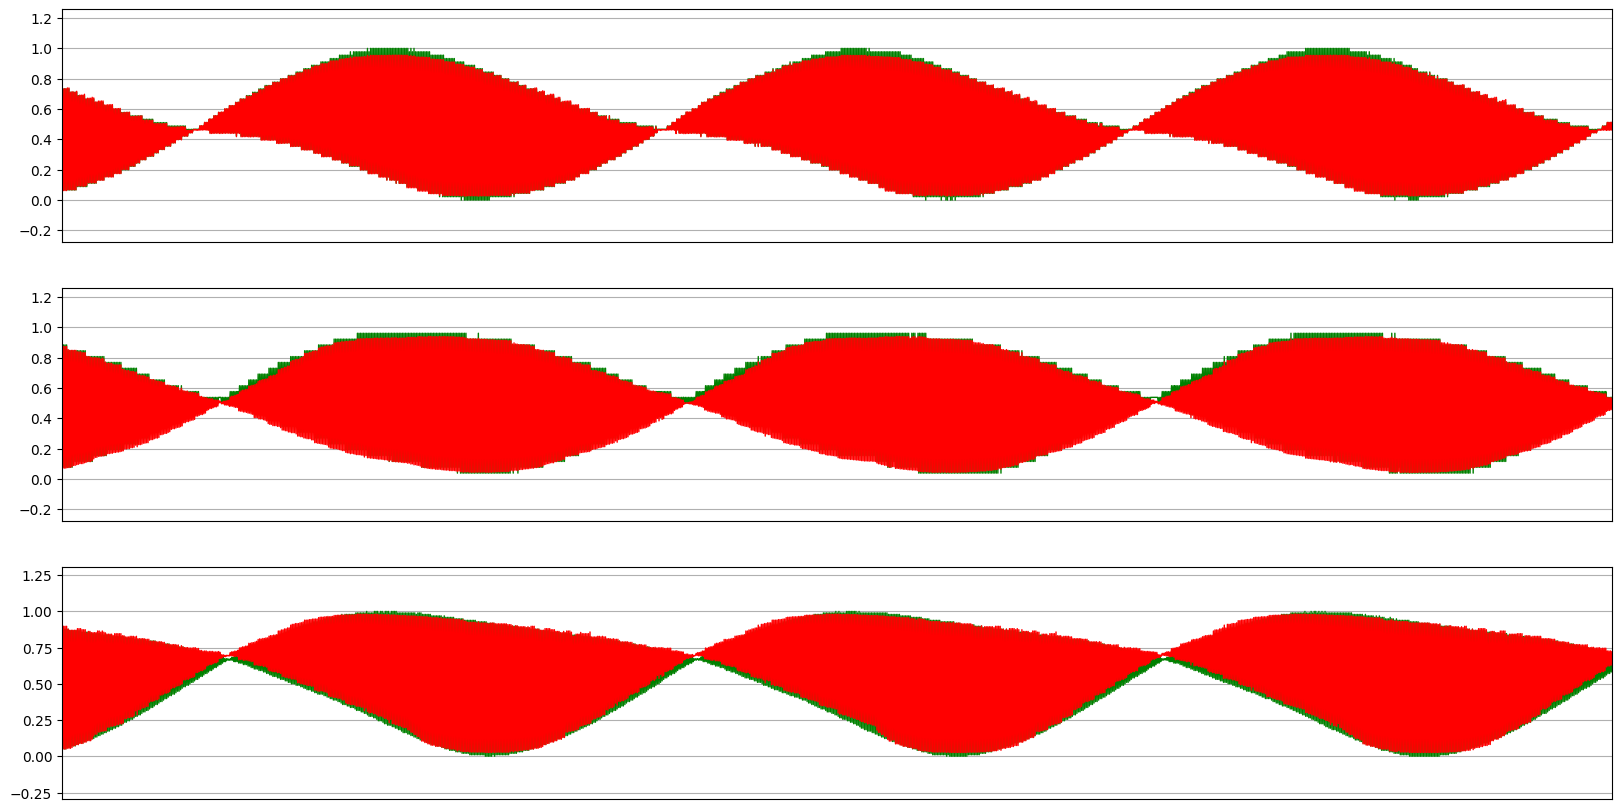

In [32]:


plotVibPattern(subset_original, subset_decoded, timestamp)

By looking at the graphs it confirms that our model has indeed learnt the correct features. It is not perfect as there is still some green that is not covered but it is too little to be a concern for now.

Hence, the model proves to be ready.

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. You will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal accelerometer data from the training set

795/795 [==============================] - 1s 1ms/step


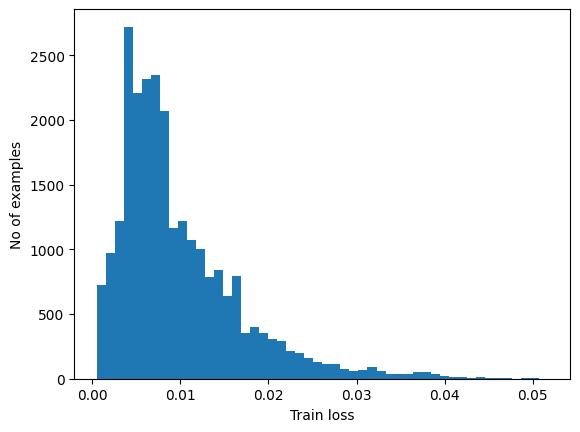

In [33]:
reconstructions = autoencoder.predict(norm_train_data)
train_loss = tf.keras.losses.mae(reconstructions, norm_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [34]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.016810845057961564


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You will learn more later in the colab.

If you examine the recontruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

### Picking a Threshold to Detect Anomalies
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

Try to maximize the accuracy, precision, and recall. Think about the application and the consequences of a false positive and a false negative. The course staff was able to acheive greater than 94% on all three at the same time!

[More details on precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [45]:
threshold = 0.04
print("Chosen Threshold: ", threshold)

Chosen Threshold:  0.04


In [36]:
len(sample)

3596

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))


In [46]:
preds, scores = predict(autoencoder, sample, threshold)
test_labels = np.array([True] * len(sample))
print_stats(preds, test_labels)

Accuracy = 0.9922135706340378
Precision = 1.0
Recall = 0.9922135706340378


## Links to Continue Learning

If you would like to learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow.

To learn more about the basics of autoencoders, try the basis for this colab, [TensorFlow's Intro to Autoencoders](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=xfNT-mlFwxVM)

For more info, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet, and check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


In [48]:
type(norm_test_data)

pandas.core.frame.DataFrame

In [49]:
norm_test_data.shape

(3596, 3)

In [50]:
norm_test_data

,x-axis,y-axis,z-axis
32718,0.577778,0.500000,0.683673
32719,0.444444,0.538462,0.642857
32720,0.600000,0.500000,0.683673
32721,0.444444,0.538462,0.642857
32722,0.600000,0.500000,0.673469
...,...,...,...
36309,0.466667,0.500000,0.540816
36310,0.488889,0.576923,0.724490
36311,0.466667,0.500000,0.551020
36312,0.488889,0.576923,0.724490


In [51]:
tf.saved_model.save(autoencoder, 'saved_model_path_noQuantize')

In [52]:
AA = 'converted_model.tflite'

with tf.compat.v1.Session() as sess:
# with tf.compat.v1.Session() as sess: #replaces the above line for use with TF2.x
  float_converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_path_noQuantize")
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(AA, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

Instructions for updating:
Use `tf.saved_model.load` instead.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.functio

Float model is 11964 bytes


# Converting the model to .tflite

In [53]:
# Save the model as a SavedModel
tf.saved_model.save(autoencoder, 'saved_model_path')

# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_path')
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert your DataFrame to a TensorFlow Dataset
norm_test_dataset = tf.data.Dataset.from_tensor_slices(norm_test_data.values)

# Define the batch size
batch_size = 32

# Create a batched dataset
test_batch = norm_test_dataset.batch(batch_size)

def representative_data_gen():
    for input_value in test_batch.take(100):
        yield [tf.cast(input_value, tf.float32)]  # Convert to FLOAT32]


converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# Save the TensorFlow Lite model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [54]:
AA = 'converted_model.tflite'

with tf.compat.v1.Session() as sess:
# with tf.compat.v1.Session() as sess: #replaces the above line for use with TF2.x
  float_converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_path")
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(AA, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

Float model is 11964 bytes


Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' 

#EXTRA STUFF FROM THIS POINT ON

Before anything this is a note to myself as I will be continuing developing code here and I will add further information after some research to see what time of model would be best for our problem.

- Anomaly detection, which is also known as classification (It's the "What" and "Which" type of questions when working with classification when working with timeseries data). The output is discrete, meaning that it's usually it is an anomaly or it isn't an anomaly.
- Frecasting (questions such as how much and how many). Output is continuous (range of values)

Challenges collecting data in anomaly detection:
- the data is often unbalanced
- anomalous data can be expensive or dangerous to capture

Methods for accurate and efficient anomaly detection: **K-means clustering, auto-encoders as well as neural networks**.